In [ ]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
pd.set_option('display.max_columns',100)
from google.colab import drive
from scipy.stats import pearsonr
import torch
from torch.nn.modules.module import Module
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.utils as utils
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import torch.optim as optim
drive.mount('/content/drive')
root_dir = "/content/drive/MyDrive/Colab Notebooks/Public Folder: SafeGraph Group /Safegraph Data/Summary"
os.chdir(f"{root_dir}")

Mounted at /content/drive


# 1. Data Preprocessing

In [ ]:
data = pd.read_csv('Safeguard_Data.csv')
data = data.sort_values(by=['date_range_start'])
data = data[~data.distance_from_home.isna()]
data = data.sort_values(by=['date_range_start'])
data['date_range_start'] = data['date_range_start'].str[0:10]
data['date_range_start'] = data['date_range_start'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data['date_range_start'] = data['date_range_start'].dt.date
data['date_range_end'] = data['date_range_end'].str[0:10]
data['date_range_end'] = data['date_range_end'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data['date_range_end'] = data['date_range_end'].dt.date

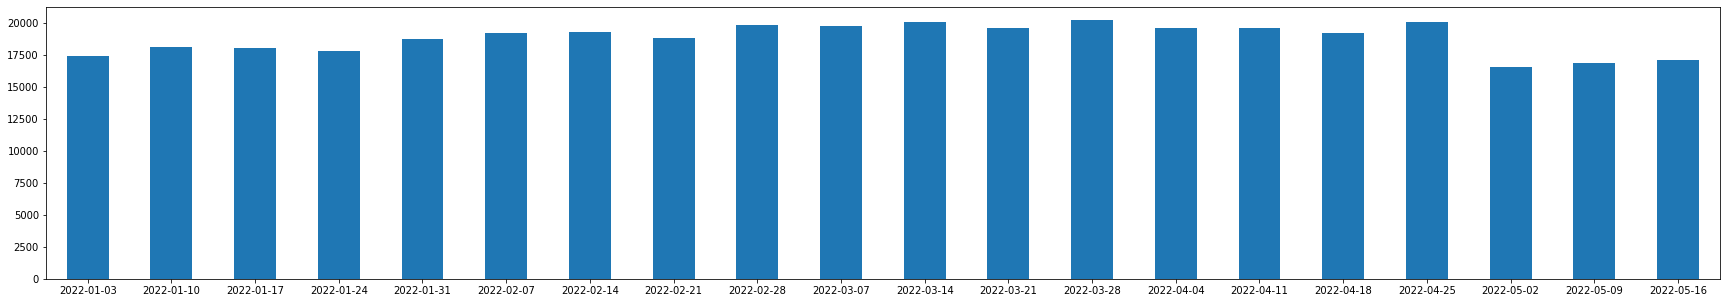

In [ ]:
data.date_range_start.value_counts(sort=False).plot.bar(figsize=(30,5), rot=0)

Get Visited list and Placekey list: 

In [ ]:
df_visited = data.groupby(['date_range_end','poi_cbg']).sum()['raw_visit_counts'].reset_index()
df_poi = data.groupby(['date_range_end','poi_cbg']).count()['placekey'].reset_index()
df = df_visited.merge(df_poi,left_on=['date_range_end','poi_cbg'],right_on=['date_range_end','poi_cbg'])

Conduct Data Cleaning on demographic csv file and merge it with visited and poi data file:

In [ ]:
demographic_cbg = pd.read_csv("demographic_cbg_with_coordinates.csv")
demographic_cbg.cbgid = demographic_cbg.cbgid.str[9:].astype('int')
demographic_cbg = demographic_cbg.loc[demographic_cbg.cbgid.isin(np.unique(df.poi_cbg)),:]
demographic_cbg = demographic_cbg.loc[(demographic_cbg.Median_Household_Income!='-')&(demographic_cbg.Margin_of_Error_Income!='**')&\
            (demographic_cbg.Margin_of_Error_Income!='***'),:]
# For those income lower than 2500, we just make it as 2500
demographic_cbg.loc[demographic_cbg.Median_Household_Income=='2,500-','Median_Household_Income'] = 2500
# For those income larger than 250000, we just make it as 250000
demographic_cbg.loc[demographic_cbg.Median_Household_Income=='250,000','Median_Household_Income'] = 250000
demographic_cbg.Median_Household_Income = demographic_cbg.Median_Household_Income.astype('int')
demographic_cbg.Margin_of_Error_Income = demographic_cbg.Margin_of_Error_Income.astype('int')
demographic_cbg.geo_location = (demographic_cbg.LATITUDE,demographic_cbg.LONGITUDE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':


In [ ]:
df = df.merge(demographic_cbg,left_on='poi_cbg',right_on='cbgid')
df = df.drop(columns=['cbgid'])
df.poi_cbg = df.poi_cbg.astype('int')
postal_to_cbg = data[['postal_code','poi_cbg']]
df.merge(postal_to_cbg, left_on = 'poi_cbg', right_on = 'poi_cbg')
#df.to_csv("overall_cbgdata.csv")
Time_Series_Data = df[['date_range_end','poi_cbg','placekey','Total_Population','Median_Household_Income']]

In [ ]:
postal_to_cbg = data[['postal_code','poi_cbg']]
df = df.merge(postal_to_cbg, left_on = 'poi_cbg', right_on = 'poi_cbg')

Merge Diagonised Case Rate into df:

In [ ]:
cases = pd.read_csv('cases.csv')
df.date_range_end = pd.to_datetime(df.date_range_end, format = '%Y-%m-%d')
cases.date_range_end = pd.to_datetime(cases.date_range_end, format = '%Y-%m-%d')
df = df.merge(cases, left_on = ['date_range_end','poi_cbg'], right_on = ['date_range_end','poi_cbg'])

In [ ]:
"""
cases = pd.read_csv('overall_cbg.csv')
cases = cases[['date_range_end', 'poi_cbg', 'case_rate']]
cases.to_csv('cases.csv', index = False)
"""

In [ ]:
"""
cases=pd.read_csv("cases.csv")
cases['week_ending'] = cases['week_ending'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))
cases['week_ending'] = cases['week_ending'].dt.date
#Make the week of the case rate and the df to be same
cases['week_ending'] = cases['week_ending'] + timedelta(days=2)
for i in df.postal_code.value_counts()[:200].index:
  for day in df.date_range_end:
    try:
      df.loc[(df.date_range_end==day)&(df.postal_code==i),'case_rate']=cases.loc[cases.week_ending==day,str(i)].values[0]
    except:
      continue

"""

In [ ]:
#df.to_csv("overall_cbgdata.csv", index = False)
Time_Series_Data = df[['date_range_end','poi_cbg','placekey','Total_Population','Median_Household_Income','case_rate','raw_visit_counts']]
Time_Series_Data = Time_Series_Data.drop_duplicates()
Time_Series_Data

,date_range_end,poi_cbg,placekey,Total_Population,Median_Household_Income,case_rate,raw_visit_counts
0,2022-01-10,360050002002,1,1542,74050,3853.80,11
30,2022-01-17,360050002002,2,1542,74050,1590.24,36
60,2022-01-24,360050002002,2,1542,74050,622.56,22
90,2022-01-31,360050002002,2,1542,74050,260.53,13
120,2022-02-07,360050002002,2,1542,74050,123.50,18
...,...,...,...,...,...,...,...
5370977,2022-05-16,360810379002,1,3037,71726,187.55,45
5370980,2022-05-23,360810379002,1,3037,71726,212.92,54
5370983,2022-05-09,360850112012,1,2037,78026,473.42,5
5370987,2022-05-16,360850112012,1,2037,78026,503.72,5


Create Feature Matrix and Correlation Matrix:

In [ ]:
droplist = []
Time_Series_Data = Time_Series_Data.drop_duplicates()
Time_Series_Data = Time_Series_Data.dropna(how ='any') 
for i in np.unique(Time_Series_Data.poi_cbg):
  if len(Time_Series_Data.loc[Time_Series_Data.poi_cbg == i,:]) < 20:
    droplist.append(i)
Time_Series_Data = Time_Series_Data.loc[~df.poi_cbg.isin(droplist)]
cbgs, length = np.unique(Time_Series_Data.poi_cbg),len(np.unique(Time_Series_Data.poi_cbg))


In [ ]:
np.save('cbg.npy', cbgs)

In [ ]:
dicts_cbg_index = {i:j for i, j in zip(range(length),np.unique(Time_Series_Data.poi_cbg))}
dicts_cbg_index_reverse = {j:i for i, j in zip(range(length),np.unique(Time_Series_Data.poi_cbg))}
Time_Series_Data.poi_cbg = Time_Series_Data.poi_cbg.map(dicts_cbg_index_reverse)
Time_Series_Data = Time_Series_Data[['date_range_end','poi_cbg','placekey','Median_Household_Income','Total_Population','case_rate','raw_visit_counts']]
date, poi = np.unique(Time_Series_Data.date_range_end), np.unique(Time_Series_Data.poi_cbg)
feature_matrix = np.zeros((len(np.unique(Time_Series_Data.date_range_end)),length,len(Time_Series_Data.columns)-2))
for i in range(len(np.unique(Time_Series_Data.date_range_end))):
  for j in range(length): 
      feature_matrix[i,j,:] = Time_Series_Data.loc[(Time_Series_Data.date_range_end==date[i])&(Time_Series_Data.poi_cbg==poi[j]),:].values.flatten()[2:]

Features: 'placekey', 'Median_Household_Income', 'Total_Population', 'case_rate', 'raw_visit_counts'

In [ ]:
np.save('feature_matrix.npy',feature_matrix)

In [ ]:
correlation = np.zeros((length,length))
for i in range(length):
  series_i = Time_Series_Data.loc[Time_Series_Data.poi_cbg==i,'raw_visit_counts']
  correlation[i,i] = 1
  for j in range(i+1,length):
    series_j = Time_Series_Data.loc[Time_Series_Data.poi_cbg==j,'raw_visit_counts']
    corr = pearsonr(series_i,series_j)[0]
    correlation[i,j] = pearsonr(series_i,series_j)[0]
    correlation[j,i] = pearsonr(series_i,series_j)[0]

In [ ]:
np.save('correlation.npy',correlation)

# 2. Realize the traffic Gan

We consider to use the traffic gan model to fit on the safegraph data. Besides, we try to use different corrlation method to make comparison: 
Correlation.npy --> time series correlation between different cbg data 
 

Using Traffic Gan network with MSE loss and time series correlation matrix: 

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, n_i, n_h, n_o):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(n_i, n_h)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(n_h, n_o)
    def forward(self, input):
        input = self.linear1(input)
        input = self.relu(input)
        input = self.linear2(input)
        return input
class GraphConvolution(Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        #print(self.weight)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adjs):
        support = torch.matmul(input, self.weight)
        output = torch.matmul(adjs, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
            + str(self.in_features) + ' -> ' \
            + str(self.out_features) + ')'

class Generator(nn.Module):
    def __init__(self, infeat, hid, outfeat):
        super(Generator, self).__init__()
        # infeat = init_dimension + condition_num
        # outfeat = 1
        self.gconv1 = GraphConvolution(infeat, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.gconv2 = GraphConvolution(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.gconv3 = GraphConvolution(32, 16)
        self.mlp1 = MLP(16,8,1)


    def forward(self, x, adj):
        # input noise x <- (batch_size, pixel_num, init_dimension)
        # input adjacency matrix <- (batch_size, region_width * region_length, region_width * region_length)
        x = F.relu(self.bn1(self.gconv1(x, adj)))
        x = F.relu(self.bn2(self.gconv2(x, adj)))
        x = self.gconv3(x, adj)
        x = self.mlp1(x)
        #x = F.relu(self.bn4(self.gconv4(x, adj)))
        #x = x.view(list(x.size())[0], -1)
        #x = torch.tanh(self.fc5(x))
        #x = x.view(list(x.size())[0], -1, 1)
        return x

In [ ]:
scaler = StandardScaler()
def normalization(feature_matrix,weight=2):
  feature_mat = np.zeros((feature_matrix.shape[0],feature_matrix.shape[1],feature_matrix.shape[2]))
  target = np.zeros((feature_matrix.shape[0],feature_matrix.shape[1]))
  for i in range(feature_matrix.shape[0]):
    feature_vector = feature_matrix[i]
    f1 = scaler.fit_transform(feature_vector[:,0].reshape(-1,1)).reshape(-1,1)
    f2 = scaler.fit_transform(feature_vector[:,1].reshape(-1,1)).reshape(-1,1)
    f3 = scaler.fit_transform(feature_vector[:,2].reshape(-1,1)).reshape(-1,1)
    f4 = scaler.fit_transform(feature_vector[:,3].reshape(-1,1)).reshape(-1,1)
    visit_nums = scaler.fit_transform(feature_vector[:,4].reshape(-1,1)).reshape(-1,1)
    feature_vector = np.stack([f1,f2,f3,f4,weight*visit_nums],axis=1).reshape(feature_matrix.shape[1],feature_matrix.shape[2])
    feature_mat[i] = feature_vector
    target[i] = visit_nums.flatten()
  return feature_mat, target

In [ ]:
feature_matrix = np.load('feature_matrix.npy')
corrlation = np.load('correlation.npy').astype(np.float32)
feature_matrix,target = normalization(feature_matrix)
feature_matrix = torch.tensor(feature_matrix.astype(np.float32))
adj = torch.tensor(corrlation)
target = torch.tensor(target.astype(np.float32))

In [ ]:
def get_features(time_step, feature_matrix):
  features = np.zeros((20-time_step,feature_matrix.shape[1],feature_matrix.shape[2]*time_step))
  results = np.zeros((20-time_step,feature_matrix.shape[1],1))
  for i in range(20-time_step):
    for j in range(feature_matrix.shape[1]):
      features[i,j,:] = feature_matrix[i:i+time_step,j,:].flatten()
      results[i,j,:] = feature_matrix[i+time_step,j,-1]
  features = torch.tensor(features.astype(np.float32))
  results = torch.tensor(results.astype(np.float32))
  return features, results
time_step = 5
features, results = get_features(time_step, feature_matrix)
train_idx=int(0.8*features.shape[0])
train_feature, train_result=features[:train_idx,:,:],results[:train_idx,:,:]
test_feature, test_result=features[train_idx:,:,:],results[train_idx:,:,:]

In [ ]:
min_val_loss = np.inf
epochs = 1000
train_mean, test_mean = np.zeros((epochs,1)), np.zeros((epochs,1))
model = Generator(time_step*5+50, 32, 1).to(device)#time_step*5: feature nums, 32: hid layer, 1:output
loss = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(),lr=0.001)
for epoch in tqdm_notebook(range(1,epochs + 1)):
    train_mean_loss, test_mean_loss, n, n1 = np.zeros((train_feature.shape[0],1)), np.zeros((test_feature.shape[0],1)), train_feature.shape[0], test_feature.shape[0]
    for i in range(n):
      #train_loss
      noise = torch.randn(train_feature.shape[1], 50)
      noise = torch.concat([noise, train_feature[i]], dim = 1) 
      train = model(noise, adj)
      train_loss = loss(train, train_result[i])
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()
      train_mean_loss[i] = train_loss.detach().numpy()
    for i in range(n1):
      noise2 = torch.randn(test_feature.shape[1], 50)
      noise2 = torch.concat([noise2, test_feature[i]], dim = 1)
      test = model(noise2, adj)
      test_loss = loss(test, test_result[i])
      test_mean_loss[i] = test_loss.detach().numpy()
    train_mean[epoch - 1], test_mean[epoch - 1] = train_mean_loss.mean(), test_mean_loss.mean()
    if mean_loss.mean() < min_val_loss:
      min_val_loss = mean_loss.mean()
    print('Epoch: {:03d} | Lr: {:.20f} |Train loss: {:.8f}|Test loss: {:.8f}'.\
          format(epoch, optimizer.param_groups[0]['lr'], train_mean_loss.mean(), test_mean_loss.mean()))
print('\nTraining finished.\n')

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 001 | Lr: 0.00100000000000000002 |Train loss: 99.43942547|Test loss: 31.76049169
Epoch: 002 | Lr: 0.00100000000000000002 |Train loss: 39.65911627|Test loss: 35.30692164
Epoch: 003 | Lr: 0.00100000000000000002 |Train loss: 20.53309695|Test loss: 18.14222177
Epoch: 004 | Lr: 0.00100000000000000002 |Train loss: 9.64450860|Test loss: 13.78166946
Epoch: 005 | Lr: 0.00100000000000000002 |Train loss: 8.07128894|Test loss: 11.95709324
Epoch: 006 | Lr: 0.00100000000000000002 |Train loss: 9.12281446|Test loss: 6.58923546
Epoch: 007 | Lr: 0.00100000000000000002 |Train loss: 7.55629388|Test loss: 8.74494664
Epoch: 008 | Lr: 0.00100000000000000002 |Train loss: 6.75945576|Test loss: 8.13903284
Epoch: 009 | Lr: 0.00100000000000000002 |Train loss: 8.25517845|Test loss: 6.49590731
Epoch: 010 | Lr: 0.00100000000000000002 |Train loss: 6.28071014|Test loss: 6.68143956
Epoch: 011 | Lr: 0.00100000000000000002 |Train loss: 5.96178961|Test loss: 6.37758700
Epoch: 012 | Lr: 0.00100000000000000002 |Train

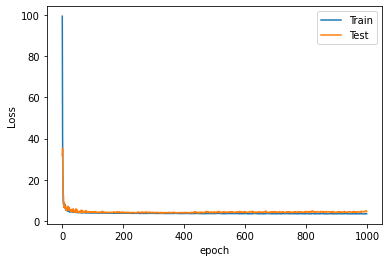

In [ ]:
plt.plot(np.arange(1000), train_mean)
plt.plot(np.arange(1000), test_mean)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['Train','Test'])

Try to use different correlation matrix:
corrleation = 1/ (h^x)  
h = 2: training loss = 2.88, testing loss = 3.59\
h = 3: training loss = 2.31, testing loss = 3.42\
h = 4: training loss = 2.26, testing loss = 3.24

In [ ]:
time_step = 5
feature_matrix = np.load('feature_matrix.npy')
corrlation = np.load('correlation_2.npy').astype(np.float32)
feature_matrix,target = normalization(feature_matrix)
feature_matrix = torch.tensor(feature_matrix.astype(np.float32))
adj = torch.tensor(corrlation)
target = torch.tensor(target.astype(np.float32))
features, results = get_features(time_step, feature_matrix)
train_idx = int(0.8*features.shape[0])
train_feature, train_result = features[:train_idx,:,:], results[:train_idx,:,:]
test_feature, test_result = features[train_idx:,:,:], results[train_idx:,:,:]

In [ ]:
min_val_loss = np.inf
epochs = 1000
train_mean, test_mean = np.zeros((epochs,1)), np.zeros((epochs,1))
model = Generator(time_step*5+50, 32, 1).to(device)#time_step*5: feature nums, 32: hid layer, 1:output
loss = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(),lr=0.001)
for epoch in tqdm_notebook(range(1,epochs + 1)):
    train_mean_loss, test_mean_loss, n, n1 = np.zeros((train_feature.shape[0],1)), np.zeros((test_feature.shape[0],1)), train_feature.shape[0], test_feature.shape[0]
    for i in range(n):
      #train_loss
      noise = torch.randn(train_feature.shape[1], 50)
      noise = torch.concat([noise, train_feature[i]], dim = 1) 
      train = model(noise, adj)
      train_loss = loss(train, train_result[i])
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()
      train_mean_loss[i] = train_loss.detach().numpy()
    for i in range(n1):
      noise2 = torch.randn(test_feature.shape[1], 50)
      noise2 = torch.concat([noise2, test_feature[i]], dim = 1)
      test = model(noise2, adj)
      test_loss = loss(test, test_result[i])
      test_mean_loss[i] = test_loss.detach().numpy()
    train_mean[epoch - 1], test_mean[epoch - 1] = train_mean_loss.mean(), test_mean_loss.mean()
    if mean_loss.mean() < min_val_loss:
      min_val_loss = mean_loss.mean()
    print('Epoch: {:03d} | Lr: {:.20f} |Train loss: {:.8f}|Test loss: {:.8f}'.\
          format(epoch, optimizer.param_groups[0]['lr'], train_mean_loss.mean(), test_mean_loss.mean()))
print('\nTraining finished.\n')

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 001 | Lr: 0.00100000000000000002 |Train loss: 29.91359488|Test loss: 8.12398783
Epoch: 002 | Lr: 0.00100000000000000002 |Train loss: 15.41730531|Test loss: 9.00487868
Epoch: 003 | Lr: 0.00100000000000000002 |Train loss: 7.63540630|Test loss: 5.65271997
Epoch: 004 | Lr: 0.00100000000000000002 |Train loss: 6.13402291|Test loss: 5.04152393
Epoch: 005 | Lr: 0.00100000000000000002 |Train loss: 4.70910267|Test loss: 4.89197556
Epoch: 006 | Lr: 0.00100000000000000002 |Train loss: 4.41085676|Test loss: 4.51088127
Epoch: 007 | Lr: 0.00100000000000000002 |Train loss: 4.26868898|Test loss: 4.20434443
Epoch: 008 | Lr: 0.00100000000000000002 |Train loss: 4.15486201|Test loss: 4.25463104
Epoch: 009 | Lr: 0.00100000000000000002 |Train loss: 4.10175075|Test loss: 4.29898930
Epoch: 010 | Lr: 0.00100000000000000002 |Train loss: 4.05499589|Test loss: 4.14314063
Epoch: 011 | Lr: 0.00100000000000000002 |Train loss: 4.02991056|Test loss: 4.02972817
Epoch: 012 | Lr: 0.00100000000000000002 |Train loss:

In [ ]:
time_step = 5
feature_matrix = np.load('feature_matrix.npy')
corrlation = np.load('correlation_3.npy').astype(np.float32)
feature_matrix,target = normalization(feature_matrix)
feature_matrix = torch.tensor(feature_matrix.astype(np.float32))
adj = torch.tensor(corrlation)
target = torch.tensor(target.astype(np.float32))
features, results = get_features(time_step, feature_matrix)
train_idx = int(0.8*features.shape[0])
train_feature, train_result = features[:train_idx,:,:], results[:train_idx,:,:]
test_feature, test_result = features[train_idx:,:,:], results[train_idx:,:,:]

In [ ]:
min_val_loss = np.inf
epochs = 1000
train_mean, test_mean = np.zeros((epochs,1)), np.zeros((epochs,1))
model = Generator(time_step*5+50, 32, 1).to(device)#time_step*5: feature nums, 32: hid layer, 1:output
loss = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(),lr=0.001)
for epoch in tqdm_notebook(range(1,epochs + 1)):
    train_mean_loss, test_mean_loss, n, n1 = np.zeros((train_feature.shape[0],1)), np.zeros((test_feature.shape[0],1)), train_feature.shape[0], test_feature.shape[0]
    for i in range(n):
      #train_loss
      noise = torch.randn(train_feature.shape[1], 50)
      noise = torch.concat([noise, train_feature[i]], dim = 1) 
      train = model(noise, adj)
      train_loss = loss(train, train_result[i])
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()
      train_mean_loss[i] = train_loss.detach().numpy()
    for i in range(n1):
      noise2 = torch.randn(test_feature.shape[1], 50)
      noise2 = torch.concat([noise2, test_feature[i]], dim = 1)
      test = model(noise2, adj)
      test_loss = loss(test, test_result[i])
      test_mean_loss[i] = test_loss.detach().numpy()
    train_mean[epoch - 1], test_mean[epoch - 1] = train_mean_loss.mean(), test_mean_loss.mean()
    if mean_loss.mean() < min_val_loss:
      min_val_loss = mean_loss.mean()
    print('Epoch: {:03d} | Lr: {:.20f} |Train loss: {:.8f}|Test loss: {:.8f}'.\
          format(epoch, optimizer.param_groups[0]['lr'], train_mean_loss.mean(), test_mean_loss.mean()))
print('\nTraining finished.\n')

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 001 | Lr: 0.00100000000000000002 |Train loss: 11.93812346|Test loss: 6.93893401
Epoch: 002 | Lr: 0.00100000000000000002 |Train loss: 5.82775386|Test loss: 4.37393236
Epoch: 003 | Lr: 0.00100000000000000002 |Train loss: 4.81486468|Test loss: 4.13268280
Epoch: 004 | Lr: 0.00100000000000000002 |Train loss: 4.30982951|Test loss: 4.36534230
Epoch: 005 | Lr: 0.00100000000000000002 |Train loss: 4.14970404|Test loss: 4.25343068
Epoch: 006 | Lr: 0.00100000000000000002 |Train loss: 3.98158433|Test loss: 3.95898382
Epoch: 007 | Lr: 0.00100000000000000002 |Train loss: 3.88774673|Test loss: 3.93560743
Epoch: 008 | Lr: 0.00100000000000000002 |Train loss: 3.87434989|Test loss: 3.92863250
Epoch: 009 | Lr: 0.00100000000000000002 |Train loss: 3.87259175|Test loss: 3.90473167
Epoch: 010 | Lr: 0.00100000000000000002 |Train loss: 3.81497693|Test loss: 3.95709403
Epoch: 011 | Lr: 0.00100000000000000002 |Train loss: 3.78958639|Test loss: 3.96635540
Epoch: 012 | Lr: 0.00100000000000000002 |Train loss: 

In [ ]:
time_step = 5
feature_matrix = np.load('feature_matrix.npy')
corrlation = np.load('correlation_4.npy').astype(np.float32)
feature_matrix,target = normalization(feature_matrix)
feature_matrix = torch.tensor(feature_matrix.astype(np.float32))
adj = torch.tensor(corrlation)
target = torch.tensor(target.astype(np.float32))
features, results = get_features(time_step, feature_matrix)
train_idx = int(0.8*features.shape[0])
train_feature, train_result = features[:train_idx,:,:], results[:train_idx,:,:]
test_feature, test_result = features[train_idx:,:,:], results[train_idx:,:,:]

In [ ]:
min_val_loss = np.inf
epochs = 1000
train_mean, test_mean = np.zeros((epochs,1)), np.zeros((epochs,1))
model = Generator(time_step*5+50, 32, 1).to(device)#time_step*5: feature nums, 32: hid layer, 1:output
loss = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(),lr=0.001)
for epoch in tqdm_notebook(range(1,epochs + 1)):
    train_mean_loss, test_mean_loss, n, n1 = np.zeros((train_feature.shape[0],1)), np.zeros((test_feature.shape[0],1)), train_feature.shape[0], test_feature.shape[0]
    for i in range(n):
      #train_loss
      noise = torch.randn(train_feature.shape[1], 50)
      noise = torch.concat([noise, train_feature[i]], dim = 1) 
      train = model(noise, adj)
      train_loss = loss(train, train_result[i])
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()
      train_mean_loss[i] = train_loss.detach().numpy()
    for i in range(n1):
      noise2 = torch.randn(test_feature.shape[1], 50)
      noise2 = torch.concat([noise2, test_feature[i]], dim = 1)
      test = model(noise2, adj)
      test_loss = loss(test, test_result[i])
      test_mean_loss[i] = test_loss.detach().numpy()
    train_mean[epoch - 1], test_mean[epoch - 1] = train_mean_loss.mean(), test_mean_loss.mean()
    if mean_loss.mean() < min_val_loss:
      min_val_loss = mean_loss.mean()
    print('Epoch: {:03d} | Lr: {:.20f} |Train loss: {:.8f}|Test loss: {:.8f}'.\
          format(epoch, optimizer.param_groups[0]['lr'], train_mean_loss.mean(), test_mean_loss.mean()))
print('\nTraining finished.\n')

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 001 | Lr: 0.00100000000000000002 |Train loss: 4.72029203|Test loss: 4.70033948
Epoch: 002 | Lr: 0.00100000000000000002 |Train loss: 3.94052432|Test loss: 3.84058642
Epoch: 003 | Lr: 0.00100000000000000002 |Train loss: 3.76674881|Test loss: 3.80361199
Epoch: 004 | Lr: 0.00100000000000000002 |Train loss: 3.63752900|Test loss: 3.75171733
Epoch: 005 | Lr: 0.00100000000000000002 |Train loss: 3.61822426|Test loss: 3.74272887
Epoch: 006 | Lr: 0.00100000000000000002 |Train loss: 3.58386453|Test loss: 3.76500058
Epoch: 007 | Lr: 0.00100000000000000002 |Train loss: 3.55360880|Test loss: 3.67423010
Epoch: 008 | Lr: 0.00100000000000000002 |Train loss: 3.55163592|Test loss: 3.68677600
Epoch: 009 | Lr: 0.00100000000000000002 |Train loss: 3.52698169|Test loss: 3.67937930
Epoch: 010 | Lr: 0.00100000000000000002 |Train loss: 3.52045252|Test loss: 3.69238106
Epoch: 011 | Lr: 0.00100000000000000002 |Train loss: 3.54159373|Test loss: 3.81574535
Epoch: 012 | Lr: 0.00100000000000000002 |Train loss: 3